# NAME  :Souri Yaswanth Krishna
# Reg.No:19bci7070
# CSE4026 LAB-5


#  Question 1: Perform Transfer Learning with Resnet
Below i used cnn model to train the model and used it for resnet50 to do transfer learningfor the given flowers data

1.CNN that build from scratch




2.Resnet 50 using transfer learning


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!unzip "/content/drive/MyDrive/yaswanthsdeeplearning/test-20211027T113410Z-001.zip" -d "/content/flowers"

In [ ]:
!unzip "/content/drive/MyDrive/yaswanthsdeeplearning/train-20211027T113145Z-001.zip" -d "/content/flowers"

In [ ]:
data_dir ="/content/flowers"

Data 

In [ ]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)
database = ImageFolder(data_dir, transform=transformer)

In [ ]:
database.classes

['test', 'train']

In [ ]:
flower_name_dict={'daisy':0 ,
                  'dandelion':1,
                  'rose':2 ,
                  'sunflower':3 ,
                  'tulip':4}

def encode_label(img_label):
    return flower_name_dict[img_label] 

In [ ]:
flower_label = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

In [ ]:
def show_batch(dl,invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

def show_sample(image, label,invert=True):
    print("Label :" +database.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :test(0)


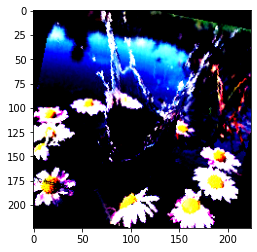

In [ ]:
show_sample(*database[1])

# Put them in Val_set and train_set

In [ ]:
validation_size = 500
training_size = len(database) - validation_size

In [ ]:
train_ds, val_ds_main = random_split(database,[training_size, validation_size])
val_ds, test_ds  = random_split(val_ds_main,[300, 200])
len(train_ds), len(val_ds)


(3868, 300)

In [ ]:
batch_size=32

In [ ]:
train_dl = DataLoader(train_ds, batch_size , shuffle=True)
val_dl = DataLoader(val_ds,batch_size)
test_dl = DataLoader(test_ds, batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


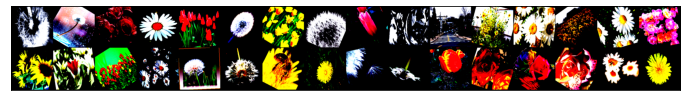

In [ ]:
show_batch(train_dl,invert=True)

# 1. Training the Image Classification using own build CNN

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = FlowerModel()
model

FlowerModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
 for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 224, 224])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


out.shape: torch.Size([32, 5])
out[0]: tensor([ 0.0015, -0.0226,  0.0049,  0.0201,  0.0338], grad_fn=<SelectBackward>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# Get GPU up on running

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Training and Validation Datasets
While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);


In [ ]:
model = to_device(FlowerModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.0, 'val_loss': 1.627910852432251}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
try1 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6640, val_loss: 0.6118, val_acc: 0.6990
Epoch [1], train_loss: 0.6003, val_loss: 0.6163, val_acc: 0.6990
Epoch [2], train_loss: 0.6054, val_loss: 0.6278, val_acc: 0.6990
Epoch [3], train_loss: 0.5994, val_loss: 0.6244, val_acc: 0.6990
Epoch [4], train_loss: 0.6009, val_loss: 0.6128, val_acc: 0.6990
Epoch [5], train_loss: 0.5983, val_loss: 0.6132, val_acc: 0.6990
Epoch [6], train_loss: 0.5987, val_loss: 0.6127, val_acc: 0.6990
Epoch [7], train_loss: 0.5977, val_loss: 0.6177, val_acc: 0.6990
Epoch [8], train_loss: 0.5975, val_loss: 0.6121, val_acc: 0.6990
Epoch [9], train_loss: 0.6032, val_loss: 0.6118, val_acc: 0.6990
CPU times: user 14min 53s, sys: 21.7 s, total: 15min 14s
Wall time: 15min 12s


In [ ]:
def plot_accuracies(try1):
    accuracies = [x['val_acc'] for x in try1]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

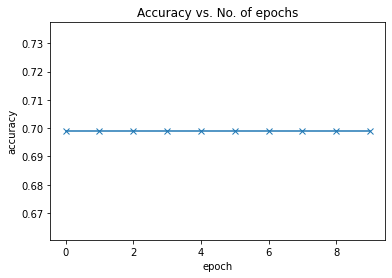

In [ ]:
plot_accuracies(try1)

In [ ]:
def plot_losses(try1):
    train_losses = [x.get('train_loss') for x in try1]
    val_losses = [x['val_loss'] for x in try1]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

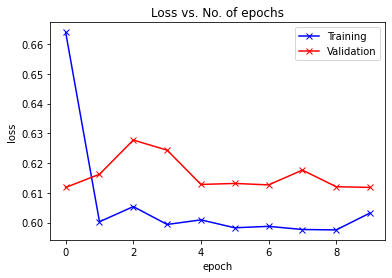

In [ ]:
plot_losses(try1)

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

{'val_acc': 0.7232142686843872, 'val_loss': 0.5905534625053406}

As you can see the val_acc is only 67% when using CNN that are bulid from scratch. Now let try pre-trained model see we can get better accurate.

# Predict the image 

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: train , Predicted: daisy


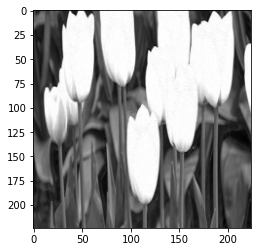

In [ ]:
img, label = test_ds[1]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

Label: train , Predicted: dandelion


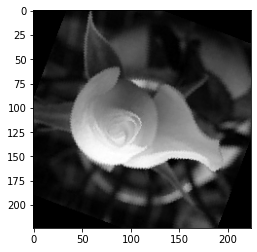

In [ ]:
img, label = test_ds[5]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

# Saving the model work

In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')

In [ ]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 3.1 MB/s 


In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='normalCNNtry2', 
                       epochs=num_epochs, 
                       lr=lr, 
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=try1[-1]['val_loss'], 
                   val_acc=try1[-1]['val_acc'],
                   train_loss=try1[-1]['train_loss'])

[jovian] Metrics logged.


In [ ]:
project_name='Flower-classification'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['Flower-classification.pth'])

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab


# Question 1: Transfer Learning method using Restnet50 (Pre-trained) 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModelResnet50(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(FlowerModelResnet50(), device)
evaluate(model, val_dl)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

{'val_acc': 0.3739583492279053, 'val_loss': 1.5499799251556396}

In [ ]:
epochs = 10
opt_func_1 = torch.optim.Adam
lr_1 = 0.001

In [ ]:
%%time
try2 = fit(epochs, lr_1, model, train_dl, val_dl, opt_func_1)

Epoch [0], train_loss: 1.1393, val_loss: 1.1326, val_acc: 0.5229
Epoch [1], train_loss: 1.1326, val_loss: 1.1326, val_acc: 0.5437
Epoch [2], train_loss: 1.1327, val_loss: 1.1326, val_acc: 0.5229
Epoch [3], train_loss: 1.1326, val_loss: 1.1326, val_acc: 0.5031
Epoch [4], train_loss: 1.1326, val_loss: 1.1327, val_acc: 0.5063
Epoch [5], train_loss: 1.1322, val_loss: 1.1325, val_acc: 0.5927
Epoch [6], train_loss: 1.1317, val_loss: 1.1309, val_acc: 0.6740
Epoch [7], train_loss: 1.1334, val_loss: 1.1326, val_acc: 0.5719
Epoch [8], train_loss: 1.1326, val_loss: 1.1327, val_acc: 0.6000
Epoch [9], train_loss: 1.1314, val_loss: 1.1344, val_acc: 0.5219
CPU times: user 11min 27s, sys: 6min 39s, total: 18min 7s
Wall time: 18min 5s


In [ ]:
evaluate(model, test_dl)

{'val_acc': 0.5446428656578064, 'val_loss': 1.1351923942565918}

Our val_acc when using Retnet50 is 73%. It is not that good let try retnet 18 and see.

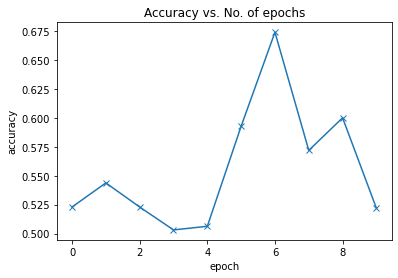

In [ ]:
def plot_accuracies(try2):
    accuracies = [x['val_acc'] for x in try2]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try2)

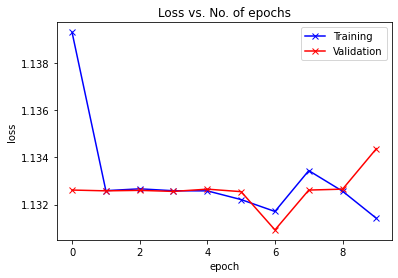

In [ ]:
def plot_losses(try2):
    train_losses = [x.get('train_loss') for x in try2]
    val_losses = [x['val_loss'] for x in try2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try2)

As you can see the **Validation** graph is increase in some point of training. This mean the model is overfitting and it is bad because it is specialize in this model but not as general.When we train our model we want to make sure the model is generalise as much as possible.

# Predict image

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: train , Predicted: rose


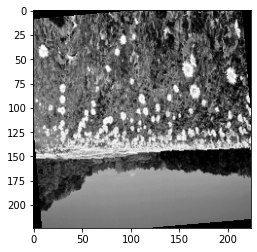

In [ ]:
img, label = test_ds[70]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

Label: train , Predicted: daisy


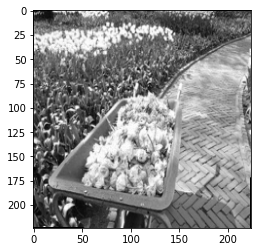

In [ ]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()

In [ ]:

jovian.log_hyperparams(arch='Restnet50_Transfer_Learning', 
                       epochs=epochs, 
                       lr=lr_1, 
                       opt=opt_func_1.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=try1[-1]['val_loss'], 
                   val_acc=try1[-1]['val_acc'],
                   train_loss=try1[-1]['train_loss'])

[jovian] Metrics logged.


In [ ]:
project_name='Flower-classification'
jovian.commit(project=project_name, environment=None, outputs=['Flower-classification.pth'])

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab


# Question 2: Do Training for Non-Dense layers while using Transfer learning

VGG has 3 fully connected layers, whereas in Resnet it only has one fully connected layer therefore in order to do fine tuning i intend to train only the fully connected so i unfroze only final layer and trained it.

In order to do fine tuning, since i wanted to only unfreeze final block so i'll freeze layers from 1 to 153 and unfreeze layers from 154 till end and train them .

## Model Building

* This model's architecture is similar to the one before but the only difference here is training final layer.

In [ ]:
#set up random seed
tf.random.set_seed(9)
 

model2=tf.keras.applications.ResNet50V2(include_top=False,input_shape=(100,100,3))


# the loop here makes sure that only final block layers are trained.
for layer in model2.layers[:154]:
   layer.trainable = False
for layer in model2.layers[154:]:
   layer.trainable = True

# printing out layer name as well as their trainable state.
for i, layer in enumerate(model2.layers):
   print(i, layer.name, layer.trainable)

0 input_5 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
#set up random seeed
tf.random.set_seed(9)

#after training only the final layer those outputs are flattened 
flatten_layer = layers.Flatten()(model2.output)

# which then goes through with another layer of 512 units
flattened_fc_layer = layers.Dense(512, activation='relu')(flatten_layer)

flattened_fc_softmax_layer = layers.Dense(5, activation='softmax')(flattened_fc_layer)


model2= Model(inputs=model2.inputs, outputs=flattened_fc_softmax_layer)

## Compiling & Fitting a model

In [ ]:
tf.random.set_seed(9)

model2.compile(loss='categorical_crossentropy',
               metrics=['accuracy'],
               optimizer='adam')


history = model2.fit(tr_data,
                     validation_data = te_data,
                     epochs=4)

Epoch 1/4
50/50 [==============================] - 34s 594ms/step - loss: 1.4539 - accuracy: 0.6376 - val_loss: 4.2785 - val_accuracy: 0.5757
Epoch 2/4
50/50 [==============================] - 28s 573ms/step - loss: 0.6738 - accuracy: 0.7618 - val_loss: 6.2088 - val_accuracy: 0.5603
Epoch 3/4
50/50 [==============================] - 29s 575ms/step - loss: 0.5436 - accuracy: 0.8067 - val_loss: 70.0877 - val_accuracy: 0.5423
Epoch 4/4
50/50 [==============================] - 28s 570ms/step - loss: 0.6072 - accuracy: 0.7971 - val_loss: 9.8083 - val_accuracy: 0.5578


## Summary

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 52, 52, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

## Conclusion

* when `Fine_tuning` is applied the model's accuracy decreased

# Question 4: Look at the Weights Repository- TensorFlowHub and Implement new models on 102 Oxford Flowers Dataset

Link: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/



## Importing Packages

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob, os
import tarfile
import scipy.io
import PIL
from PIL import ImageOps, ImageFilter
from sklearn.model_selection import train_test_split

#setting up variable to reusability
IMG_SHAPE=(224,224)
BATCH_SIZE=32

## Preprocessing

In [ ]:
#set-up directories
DATA_PATH = '/content/drive/MyDrive/deep Learning Lab/oxford_flowers102/' ## used to extract .tgz file
PATH='/content/drive/MyDrive/deep Learning Lab/oxford_flowers102/flowers_img/' ## used to store images

In [ ]:
# Get all the data from the archive files in the directory
def get_filenames(tgz):
    with tarfile.open(tgz) as file:
        return[i.name for i in file.getmembers() if i.isfile()]

# sorting data into a dataframe
df = pd.DataFrame()
df['Id'] = sorted(get_filenames(DATA_PATH + '102flowers.tgz'))
df['Category'] = scipy.io.loadmat(DATA_PATH + 'imagelabels.mat')['labels'][0] - 1 # classes for earch 0,..,N
df['Category'] = df['Category'].astype('str')

df.head()

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [ ]:
# Unzipping the images that are in the dataset
opened_tgz = tarfile.open(DATA_PATH + "102flowers.tgz")
opened_tgz.extractall(PATH)

print(os.listdir(PATH + 'jpg')[:12])

['image_00009.jpg', 'image_01701.jpg', 'image_01890.jpg', 'image_00623.jpg', 'image_03604.jpg', 'image_00190.jpg', 'image_02534.jpg', 'image_01087.jpg', 'image_07599.jpg', 'image_02407.jpg', 'image_04357.jpg', 'image_00094.jpg']


## Visualising data

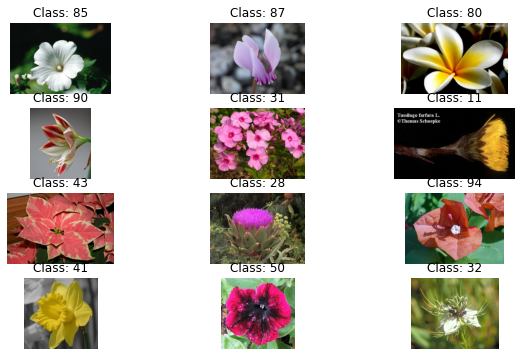

In [ ]:
plt.figure(figsize = (10, 6))

random_image = df.sample(n = 12)
random_image_paths = random_image['Id'].values
random_image_category = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    ax = PIL.Image.open(PATH + path)
    plt.subplot(4, 3, index + 1)
    plt.imshow(ax)
    plt.title("Class: " + str(random_image_category[index]))
    plt.axis("off")

plt.show();

In [ ]:
# train/test splitting

X_train, X_test, y_train, y_test = train_test_split(df['Id'], df['Category'], test_size = 0.2, stratify = df['Category'])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train['Category'] = y_train
X_test['Category'] = y_test

print(f"Shape of the Train Data: {X_train.shape}\nShape of the Test Data: {X_test.shape}")

Shape of the Train Data: (6551, 2)
Shape of the Test Data: (1638, 2)


In [ ]:
# Augmentation is very important part when you do not have a big data to train the model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   rotation_range = 50, shear_range = 0.2,
                                   zoom_range = [0.75, 1.25],
                                   brightness_range = [0.5, 1.5],
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [ ]:
# Wrapping all data to the generator
tr_data = train_datagen.flow_from_dataframe(dataframe = X_train, directory = PATH, x_col = 'Id', y_col = "Category",
                                                    target_size = IMG_SHAPE, batch_size = BATCH_SIZE, class_mode = 'categorical',
                                                    shuffle = True, seed = 9)

te_data = test_datagen.flow_from_dataframe(dataframe = X_test, directory = PATH, x_col = 'Id', y_col = "Category", 
                                                  target_size = IMG_SHAPE, batch_size = BATCH_SIZE, class_mode = 'categorical',
                                                 shuffle = False, seed = 42)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [ ]:
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(102, activation="softmax", name="output_layer")
  ])
    
  return model  

In [ ]:
# Model's URL from tensorflow hub

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

## Resnet50 Model

In [ ]:
# Building , compiling & fitting our Resnet Model
tf.random.set_seed(9)

resnet_model=create_model(resnet_url)

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

resnet_history = resnet_model.fit(tr_data,
                                  epochs=5,
                                  steps_per_epoch=len(tr_data),
                                  validation_data=te_data,
                                  validation_steps=len(te_data))

Epoch 1/5
205/205 [==============================] - 161s 758ms/step - loss: 2.1434 - accuracy: 0.5285 - val_loss: 0.9895 - val_accuracy: 0.7821
Epoch 2/5
205/205 [==============================] - 156s 762ms/step - loss: 0.8289 - accuracy: 0.8020 - val_loss: 0.6663 - val_accuracy: 0.8492
Epoch 3/5
205/205 [==============================] - 154s 750ms/step - loss: 0.5733 - accuracy: 0.8626 - val_loss: 0.5509 - val_accuracy: 0.8571
Epoch 4/5
205/205 [==============================] - 151s 734ms/step - loss: 0.4595 - accuracy: 0.8915 - val_loss: 0.4919 - val_accuracy: 0.8730
Epoch 5/5
205/205 [==============================] - 157s 766ms/step - loss: 0.3820 - accuracy: 0.9087 - val_loss: 0.4463 - val_accuracy: 0.8840


## Efficient net model

In [ ]:
# Building , compiling & fitting our EfficientNet Model
tf.random.set_seed(9)


efficientnet_model=create_model(efficientnet_url)

efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

efficientnet_history = resnet_model.fit(tr_data,
                                  epochs=2,
                                  steps_per_epoch=len(tr_data),
                                  validation_data=te_data,
                                  validation_steps=len(te_data))

Epoch 1/2
205/205 [==============================] - 152s 739ms/step - loss: 0.3291 - accuracy: 0.9199 - val_loss: 0.3978 - val_accuracy: 0.8950
Epoch 2/2
205/205 [==============================] - 148s 722ms/step - loss: 0.2893 - accuracy: 0.9276 - val_loss: 0.3839 - val_accuracy: 0.8968
